### Basic imports for the project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import cv2

from stable_baselines3.common.callbacks import BaseCallback

2023-04-26 19:21:51.251378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Imports that will emulate the game and an action space

In [2]:
import gym
from gym.envs.classic_control.rendering import SimpleImageViewer
import retro
from retro import RetroEnv
import pygame

from gym import Wrapper

pygame 2.3.0 (SDL 2.24.2, Python 3.8.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Imports for our PPO algorithm (Proximal Policy Optimization) and for pre-processing (grayscale and frame stacking)

In [3]:
from stable_baselines3 import PPO

from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

### Using GPU for training (with AMD's ROCm), checking if we have access to Cuda (at least 4 times faster training)

In [4]:
import torch
torch.cuda.is_available()

True

### Hijacking the default action space with a wrapper that will allow us to
### create our own combos of buttons

In [5]:
class Discretizer(gym.ActionWrapper):

    def __init__(self, env, combos):
        super().__init__(env)
        assert isinstance(env.action_space, gym.spaces.MultiBinary)
        buttons = env.unwrapped.buttons
        self._decode_discrete_action = []
        for combo in combos:
            arr = np.array([False]*env.action_space.n)
            for button in combo:
                arr[buttons.index(button)] = True
            self._decode_discrete_action.append(arr)

        self.action_space = gym.spaces.Discrete(len(self._decode_discrete_action))

    def action(self, act):
        return self._decode_discrete_action[act].copy()


class MaRLioDiscretizer(Discretizer):

    def __init__(self, env):
        super().__init__(env=env, 
                         combos=[
            [],
            ["RIGHT"],
            ["RIGHT","Y"],
            ["RIGHT","A"],
            ["RIGHT","Y","A"],
            ["RIGHT","Y","B"],
            ["LEFT","Y"],
            ["LEFT","Y","A"],
            ["LEFT","Y","B"],
            ["A"],
            ["B"]
            ]
        )

### Keeping our combos in a list for an easy visualization using indexing

In [6]:
combos = [
    [],
    ["RIGHT"],
    ["RIGHT","Y"],
    ["RIGHT","A"],
    ["RIGHT","Y","A"],
    ["RIGHT","Y","B"],
    ["LEFT","Y"],
    ["LEFT","Y","A"],
    ["LEFT","Y","B"],
    ["A"],
    ["B"]
    ]

### Let's add a controller dictionary that maps our buttons to our overlay

In [7]:
combo_images = {
    0: "./controller/blank.png",
    1: "./controller/right.png",
    2: "./controller/righty.png",
    3: "./controller/righta.png",
    4: "./controller/rightya.png",
    5: "./controller/rightyb.png",
    6: "./controller/lefty.png",
    7: "./controller/leftya.png",
    8: "./controller/leftyb.png",
    9: "./controller/a.png",
    10: "./controller/b.png"
}


### Storing the path of our custom data.json and scenario.json files into variables

In [8]:
data_path = "./data.json"
scenario_path = "./scenario.json"

### data.json will have memory addresses for things that we want to keep track of
### and will be accessed from the info variable once we run the environment
### scenario.json will be our way of calculating MaRLio's reward
### Let's see how they look like. 

### data.json

````
{
  "info": {
    "checkpoint": {
      "address": 5070,
      "type": "|i1"
    },
    "coins": {
      "address": 8261055,
      "type": "|u1"
    },
    "end_of_level": {
      "address": 8259846,
      "type": "|i1"
    },
    "lives": {
      "address": 8261054,
      "type": "|i1"
    },
    "powerups": {
      "address": 25,
      "type": "|i1"
    },
    "score": {
      "address": 8261428,
      "type": "<u4"
    },
    "xpos": {
      "address": 148,
      "type": "<u2"
    },
    "ypos": {
      "address": 114,
      "type": "<u4"
    },
    "yoshi_coins": {
      "address": 8262690,
      "type": "<u4"
    }
  }
}
````

### scenario.json

````
{
  "crop": [
    0,
    0,
    0,
    0
  ],
  "done": {
    "variables": {
      "lives": {
        "op": "equal",
        "reference": -1
      }
    }
  },
  "reward": {
    "variables": {
      "score": {
        "reward": 1.0
      },
      "coins": {
        "reward": 1.0
      },
      "yoshi_coins": {
        "reward": 1.0
      },
      "xpos": {
        "op": "greater",
        "reference": "last",
        "reward": 10
      },
      "ypos": {
        "op": "less",
        "reference": "last",
        "reward": 10
      },
      "xpos": {
        "op": "less",
        "reference": "last",
        "penalty": 0.1
      },
      "lives": {
        "op": "less",
        "reference": "last",
        "penalty": 1000.0
      },
      "end_of_level": {
        "op": "equal",
        "reference": 1,
        "reward": 1000000.0
      }
    }
  }
}
````

### Let's load our game, Super Mario World (SMW) from the Super Nintendo Entertainment System (SNES)
### using scenario and info kwargs, we can load our custom data.json and scenario.json
### using record kwarg, we can save the training sessions for future viewing

In [9]:
# saves recording to ./recordings/train/

env = retro.make(game="SuperMarioWorld-Snes", state="YoshiIsland1", record="./recordings/train/", scenario=scenario_path, info=data_path)

In [10]:
# saves recording to ./recordings/pred/

# env = retro.make(game="SuperMarioWorld-Snes", state="YoshiIsland1", record="./recordings/pred/", scenario=scenario_path, info=data_path)

In [11]:
# for video only, no recording

# env = retro.make(game="SuperMarioWorld-Snes", state="YoshiIsland1", scenario=scenario_path, info=data_path)

### This is where we wrap the environment in our own action space

In [12]:
disc_env = MaRLioDiscretizer(env)

In [13]:
obs = disc_env.reset()

### Let's check the index it returns and what combo we get from it

In [14]:
action = disc_env.action_space.sample()
print(action)
combos[action]

1


['RIGHT']

### Now we can use that action inside our environment, one frame at a time
### and we can use tuple unpacking, to get access to some important information about our environment

In [15]:
obs, reward, terminated, info = disc_env.step(action)
print(f"score: {reward}\nterminated: {terminated}\ninfo: {info}")

score: 0.0
terminated: False
info: {'end_of_level': 0, 'lives': 4, 'powerups': 0, 'score': 0, 'coins': 0, 'ypos': 159, 'yoshi_coins': 0, 'xpos': 16, 'checkpoint': 0}


### The image we get is a 3-dimensional tensor with a height of 224 pixels, a width of 256 pixels, and 3 color channels (RGB)

In [16]:
obs.shape

(224, 256, 3)

### Let's visualize that frame

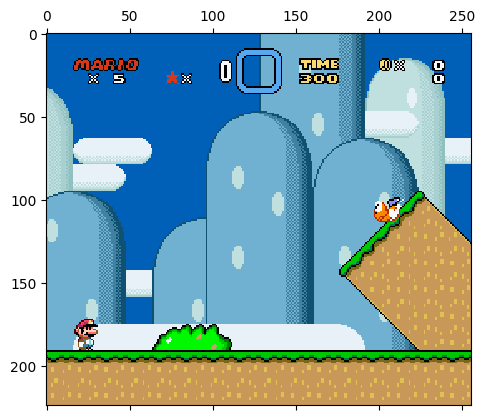

In [17]:
plt.matshow(obs)

In [18]:
# game loop with random actions
# state = disc_env.reset()

# done = False
# while not done:
#     action = disc_env.action_space.sample()
#     state, reward, done, info = disc_env.step(action)
#     disc_env.render()
#     time.sleep(0.005)
# disc_env.render(close=True)

### Let's pre-process our images
### First, grayscale. that'll reduce the size of our environment by 66%
### Second, let's vectorize everything
### Third, let's stack 4 frames, our model will get a sense of momentum

In [19]:
disc_env = GrayScaleObservation(disc_env, keep_dim=True)
disc_env = DummyVecEnv([lambda:disc_env])
disc_env = VecFrameStack(disc_env, 4, channels_order="last")

In [20]:
state = disc_env.reset()

### Let's look at a frame

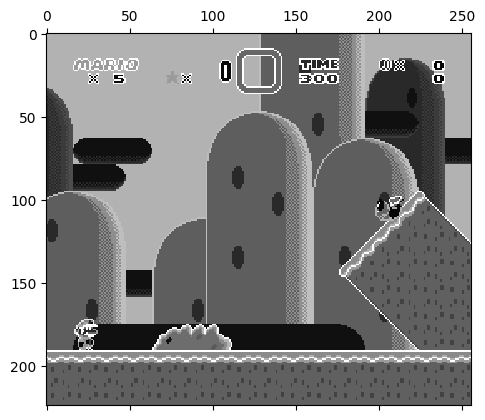

In [21]:
plt.matshow(state[0])

### This time, the (1, 224, 256, 4) shape indicates that the observation is a stack of 4 frames, 
### where each frame is a "color" (grayscale, 1 RGB channel) image with a resolution of 224x256 pixels.

In [22]:
state.shape

(1, 224, 256, 4)

### Taking 4 steps, so we don't have blank frames

In [23]:
for _ in range(3):
    state, reward, done, info = disc_env.step([disc_env.action_space.sample()])

### Let's visualize our stack of frames, with random actions from our list of combos
### We should see some movement

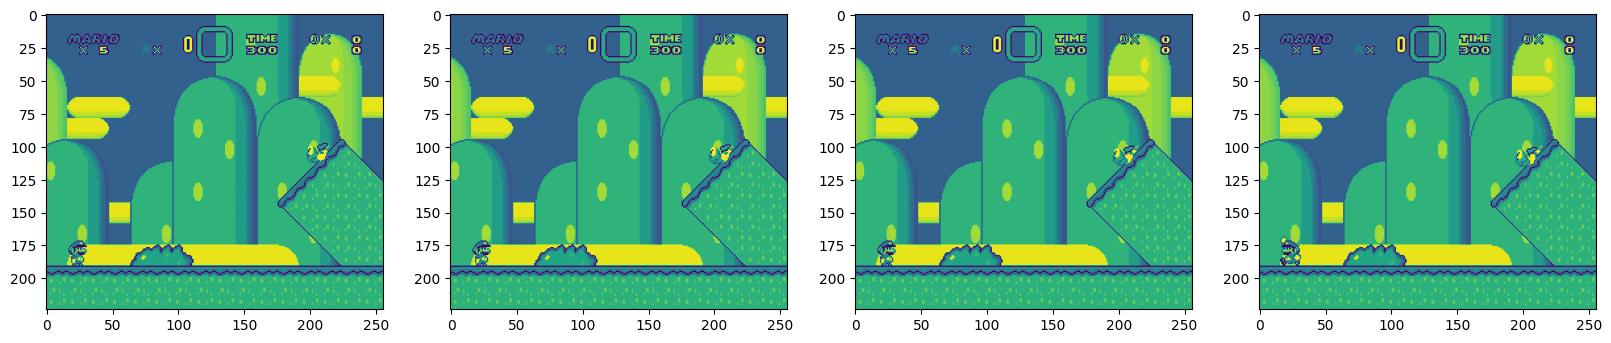

In [24]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [25]:
state = disc_env.reset()

### Defining a class that will create our logs and save our model at every check_freq

In [26]:
# callback helper function

# logs and model saving
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "best_model_{}".format(self.n_calls))
            self.model.save(model_path)

        return True

### Creating variables that points to our paths for saving the model and the logs (tensorboard)

In [27]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"

In [28]:
callback = TrainAndLoggingCallback(check_freq=500_000, save_path=CHECKPOINT_DIR)

### Keeping track of some hyperparameters for finetuning

In [29]:
# lambda params

learning_rate = lambda f:f*0.000001
# learning_rate = 0.000001
n_steps = 128
clip_range = 0.2
ent_coef = 0.01

### Instance of our PPO algorithm, with the rest of the hyperparameters set to default

In [30]:
model = PPO(
    "CnnPolicy", 
    disc_env, 
    learning_rate=learning_rate, 
    n_steps=n_steps, 
    batch_size=64, 
    n_epochs=10, 
    gamma=0.99, 
    gae_lambda=0.95, 
    clip_range=clip_range, 
    clip_range_vf=None, 
    normalize_advantage=True, 
    ent_coef=ent_coef, 
    vf_coef=0.5, 
    max_grad_norm=0.5, 
    use_sde=False, 
    sde_sample_freq=-1, 
    target_kl=None,  
    tensorboard_log=LOG_DIR, 
    policy_kwargs=None, 
    verbose=0, 
    seed=42, 
    device='auto', 
    _init_setup_model=True
    )

### This is where MaRLio starts his adventure (training)

In [31]:
model.learn(
    total_timesteps=5_000_000, 
    progress_bar=True, 
    tb_log_name="ppo",
    callback=[
    callback
    ]
)

Output()

### Let's add a powerup dictionnary, we will see what powerups MaRLio has

In [ ]:
powerup_dict = {
    0: "small",
    1: "big",
    2: "cape",
    3: "fire"
    }

### Let's load the models and predict the environment with the models' knowledge

In [ ]:
marlio = "best_model_1000000.zip"
model = PPO.load(f"./train/{marlio}")
print(f"using {marlio}")

In [ ]:
state = disc_env.reset()

In [ ]:
class ZedsEnv(RetroEnv):

    def __init__(self, game, state=retro.State.DEFAULT, scenario=None, info=None, use_restricted_actions=retro.Actions.FILTERED, 
                 record=False, players=1, inttype=retro.data.Integrations.STABLE, obs_type=retro.Observations.IMAGE, render_mode="human"):
        super().__init__(self, game, state=retro.State.DEFAULT,scenario=None, info=None,use_restricted_actions=retro.Actions.FILTERED, 
                          record=False, players=1, inttype=retro.data.Integrations.STABLE, obs_type=retro.Observations.IMAGE,render_mode="human")
        if not hasattr(self, 'spec'):
            self.spec = None
        self._obs_type = obs_type
        self.img = None
        self.ram = None
        self.viewer = None
        self.gamename = game
        self.statename = state
        self.initial_state = None
        self.players = players

    def render(self, mode='human', close=False, combo_images=None, action=None):
        viewer = SimpleImageViewer()
        if close:
            viewer.close()
            return

        img = self.get_screen() if self.img is None else self.img
        if mode == "rgb_array":
            return img
        elif mode == "human":
            if combo_images is not None:
                overlay_img = cv2.imread(combo_images[int(action)], cv2.IMREAD_UNCHANGED)
                overlay_imga = cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGBA)
                img = cv2.addWeighted(overlay_imga, 1, img, 1, 0)

                if self.viewer is None:
                    self.viewer = SimpleImageViewer()
            self.viewer.imshow(img)
            return self.viewer.isopen

In [ ]:
disc_env = ZedsEnv(disc_env)

In [ ]:
# game loop for predict

total_reward = 0
action_list = [0]
powerup = ""
check = False

done = False
while not done:

    action, _ = model.predict(state)
    state, reward, done, info = disc_env.step(action)

    if action[0] not in action_list:
        action_list.pop()
        action_list.append(action)
        # print(combos[action_list[0]])

    if info[0]["powerups"] != powerup:
        powerup = info[0]["powerups"]
        print(powerup_dict.get(powerup, "Invalid integer value"))

    if info[0]["checkpoint"] == 1 and not check:
        check = True
        print("Midlevel Checkpoint Reached: +500k reward")

    if info[0]["end_of_level"] == 1:
        print("End of level Reached: +1m reward")

    total_reward += reward
    disc_env.render(combo_images=combo_images, action=action) # only this one was changed
    time.sleep(0.005)

print("Total reward:", total_reward)

# references

In [ ]:
# videos

# https://www.youtube.com/watch?v=2eeYqJ0uBKE
# https://www.youtube.com/watch?v=qv6UVOQ0F44
# https://www.youtube.com/watch?v=fkvc9Qc5ycE
# https://www.youtube.com/@LucasThompson/videos
# https://www.youtube.com/watch?v=PxoG0A2QoFs
# https://www.youtube.com/playlist?list=PLTWFMbPFsvz3CeozHfeuJIXWAJMkPtAdS
# https://www.youtube.com/watch?v=yO4CiiigHjA
# https://www.youtube.com/playlist?list=PLTWFMbPFsvz2LIR7thpuU738FcRQbR_8I
# https://www.youtube.com/watch?v=MEt6rrxH8W4&t=7s


# github

# https://github.com/Farama-Foundation/Gymnasium
# https://github.com/MatPoliquin/stable-retro
# https://github.com/openai/gym
# https://github.com/openai/retro#readme
# https://github.com/openai/retro/tree/master/retro/data/stable
# https://github.com/CodeReclaimers/neat-python
# https://github.com/healthpotionstudios/MarioWorldAI-NEAT
# https://github.com/szmyty/OpenAI-Retro-SuperMarioWorld-SNES
# https://github.com/nicknochnack/MarioRL/blob/main/Mario%20Tutorial.ipynb


# docs

# https://retro.readthedocs.io/en/latest/getting_started.html#create-a-gym-environment
# https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
# https://stable-baselines3.readthedocs.io/en/master/
# https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/
# https://openai.com/research/gym-retro


# misc

# https://www.snesmaps.com/maps/SuperMarioWorld/SuperMarioWorld.html
# https://www.smwcentral.net/?p=memorymap&game=smw&region=ram
# https://pastebin.com/ZZmSNaHX
# https://www.videogames.ai/2022/09/01/RX-6700s-Machine-Learning-ROCm.html

In [ ]:
# scenario.json -> https://retro.readthedocs.io/en/latest/integration.html?highlight=scenario#scenario-scenario-json
# metadata.json -> https://retro.readthedocs.io/en/latest/integration.html?highlight=scenario#metadata-json
# data.json -> https://retro.readthedocs.io/en/latest/integration.html?highlight=scenario#data-json

# appendix for operations -> https://retro.readthedocs.io/en/latest/integration.html?highlight=scenario#appendix-operations

In [ ]:
# convert .bk2 to .mp4

# https://retro.readthedocs.io/en/latest/python.html#render-to-video
# python3.8 -m retro.scripts.playback_movie SuperMarioWorld-Snes-YoshiIsland3-001490.bk2

In [ ]:
# keep an eye on GPU while training (AMD using ROCm)

# watch -n 1 rocm-smi

# tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
# architecture of PPO and formula

In [ ]:
# below code not used for now

In [ ]:
# overlay_img = cv2.imread(combo_images[5], cv2.IMREAD_UNCHANGED)
# overlay_imga = cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGBA)
# merged = cv2.addWeighted(overlay_imga, 1, state[0], 1, 0)

In [ ]:
# plt.matshow(overlay_imga)

In [ ]:
# plt.matshow(merged)

In [ ]:
def render(img, mode='human', close=False, overlay_path=None, action=None):
    if close:
        viewer.close()
        return

    img = self.get_screen() if self.img is None else self.img
    if mode == "rgb_array":
        return img
    elif mode == "human":
        if overlay_path is not None:
            overlay_img = cv2.imread(overlay_path, cv2.IMREAD_UNCHANGED)
            overlay_imga = cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGBA)
            merged = cv2.addWeighted(overlay_imga, 1, img, 1, 0)

            if not hasattr(render, "viewer"):
                render.viewer = SimpleImageViewer()
            render.viewer.imshow(merged)

            return render.viewer.isopen

In [ ]:
def render(self, img, mode='human', close=False, overlay_path=None):
        if close:
            if self.viewer:
                self.viewer.close()
            return

        img = self.get_screen() if self.img is None else self.img
        if mode == "rgb_array":
            return img
        elif mode == "human":
            if self.viewer is None:
                self.viewer = SimpleImageViewer()

            overlay_img = cv2.imread(combo_images[5], cv2.IMREAD_UNCHANGED)
            overlay_imga = cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGBA)
            merged = cv2.addWeighted(overlay_imga, 1, state[0], 1, 0)
            self.viewer.imshow(merged)

            return self.viewer.isopen

In [ ]:
class ComboImageWrapper(Wrapper):
    def __init__(self, env, images_path):
        super().__init__(env)
        self.images_path = images_path

    def reset(self, **kwargs):
        observation = self.env.reset(**kwargs)
        return observation

    def step(self, action):
        overlay_img = cv2.imread(self.images_path[int(action)], cv2.IMREAD_UNCHANGED)
        overlay_imga = cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGBA)
        observation, reward, done, info = self.env.step(action)
        merged = cv2.addWeighted(overlay_imga, 1, observation[0], 1, 0)
        return merged.reshape((1, merged.shape[0], merged.shape[1], merged.shape[2])), reward, done, info

In [ ]:
pygame.init()
win = pygame.display.set_mode((800,600))
clock = pygame.time.Clock()

In [ ]:
state = disc_env.reset()

total_reward = 0
action_list = [0]
powerup = ""
check = False

done = False
while not done:
    action, _ = model.predict(state)
    overlay_img = cv2.imread(combo_images[int(action)], cv2.IMREAD_UNCHANGED)
    overlay_imga = cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGBA)
    merged = cv2.addWeighted(overlay_imga, 1, state[0], 1, 0)

    img = pygame.image.frombuffer(merged.tobytes(), merged.shape[1::-1], "RGBA")
    img = pygame.transform.scale(img, (800,600))
    win.blit(img,(0,0))
    pygame.display.flip()


    if info[0]["powerups"] != powerup:
        powerup = info[0]["powerups"]
        print(powerup_dict.get(powerup, "Invalid integer value"))

    if info[0]["checkpoint"] == 1 and not check:
        check = True
        print("Midlevel Checkpoint Reached: +500k reward")

    if info[0]["end_of_level"] == 1:
        print("End of level Goal Reached: +1m reward")

    total_reward += reward
    # env.render()
    state, reward, done, info = disc_env.step(action)
    # clock.tick(40)
    time.sleep(0.004)

print("Total reward:", total_reward)

In [ ]:
# possible playback code below

movie = retro.Movie("./recordings/train/SuperMarioWorld-Snes-YoshiIsland3-000008.bk2")
movie.step()

In [ ]:
env = retro.make(
    game=movie.get_game(),
    state=None,
    # bk2s can contain any button presses, so allow everything
    use_restricted_actions=retro.Actions.ALL,
    players=movie.players,
)
env.initial_state = movie.get_state()
env.reset()

In [ ]:
while movie.step():
    keys = []
    for p in range(movie.players):
        for i in range(env.num_buttons):
            keys.append(movie.get_key(i, p))
    env.step(keys)
    env.render()
    # time.sleep(0.004)

In [ ]:
def record_video(env, policy, out_directory, fps=30):
    images = []
    done = False
    state = env.reset()
    img = env.render(mode="rgb_array")
    images.append(img)
    while not done:
        state = torch.Tensor(state).to(device)
        # Take the action (index) that have the maximum expected future reward given that state
        action, _, _, _ = policy.get_action_and_value(state)
        state, reward, done, info = env.step(
            action.cpu().numpy()
        )  # We directly put next_state = state for recording logic
        img = env.render(mode="rgb_array")
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)